In [696]:
import numpy as np
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt
import cmath
from scipy.special import lpmn, legendre
from scipy.integrate import solve_ivp


In [697]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456

In [698]:
def get_Pleg_matrix( N, m ):

    l_max = N + abs(m) - 1

    x_arr, w = np.polynomial.legendre.leggauss(N)
    
    P_lm = np.zeros( (N,N) )

    l_arr = np.arange( 0, N ) + abs(m)
    norm = np.sqrt( (l_arr + 0.5) / np.array( [ np.prod( np.arange( l-abs(m)+1, l+abs(m)+1 ) ) for l in l_arr ] ) )

    for i, x in enumerate(x_arr):

        lpmn_at_x, _ = lpmn( m, l_max, x )

        P_lm[i,:] = lpmn_at_x[ abs(m), abs(m): ] * norm * np.sqrt( w[i] )

    if m != 0:

        Q, R = np.linalg.qr( np.transpose( P_lm ) )

        U = Q

    else:
        U = np.transpose( P_lm )

    return U

def get_laplacian_matrix( N, m ):

    U = get_Pleg_matrix( N, m )

    l_arr = np.arange( 0, N ) + abs(m)

    L2 = np.matmul( np.matmul( np.transpose(U), np.diag( l_arr * ( l_arr + 1 ) ) ), U )

    return L2

In [699]:
def potential( r, th, C_12, alpha, mu ):
    return C_12 / r**12 - alpha * mu**2 / 2 / r**6 * ( 1 + 3 * np.cos(th)**2 )

def force_field( r, th, C_12, alpha, mu ):
    F_r = + 12 * C_12 / r**13 - 3 * alpha * mu**2 / r**7 * ( 1 + 3 * np.cos( th )**2 )
    F_th = - 3 * alpha * mu**2 / 2 / r**6 * np.sin( 2 * th )

    return F_r, F_th

In [700]:
def evolution( t, V, C_12, alpha, mu, m_Ne, m_HYQ, th_arr, Pleg ):

    mass = 1./( 1./m_Ne + 1./m_HYQ )

    r = V[0]
    th = V[1]

    Psi = V[4:]

    der_V = np.zeros_like( V )

    der_V[0] = V[2] / mass
    der_V[1] = 4 * V[3] / m_HYQ

    # F_r, F_th = force_field( r, th_arr, C_12, alpha, mu )

    # der_V[2] = np.sum( F_r * np.abs(np.matmul( np.conj(np.transpose(Pleg)), Psi ))**2 )
    # der_V[3] = np.sum( F_th * np.abs(np.matmul( np.conj(np.transpose(Pleg)), Psi ))**2 )
    
    der_V[2], der_V[3] = force_field( r, th, C_12, alpha, mu )

    Pot = np.matmul( Pleg, np.matmul( np.diag( potential( r, th_arr, C_12, alpha, mu ) ), np.conj(np.transpose( Pleg ) ) ) )

    der_V[4:] = - 1j * np.matmul( Pot, Psi )

    return der_V

In [701]:


# ------------------potential------------------------
C_12 = 2.5e7
mu = 2.38 * Db2au
alpha = 27.8 / au2A**3

# ------------------particles------------------------
Be = 5614 * 1.5198298460570 * 1e-10
m_HYQ = 110 * 1822.8884

m_Ne = 20 * 1822.8884

# ---------------initial conditions------------------
E_col = 0.5 / au2eV

j_init = 0
omega = 0

r_0 = 50.
th_0 = np.pi / 4.

p_theta = ()

# --------------simulation parameters----------------
t_max = 10 / au2ps
N_states = 140
N_t = 1000

In [716]:

j_max = N_states - 1 + abs( omega )
m_eff = 1./( 1./m_Ne + 1./m_HYQ )
Re = np.sqrt( 2./m_HYQ/Be )

print( Re, m_eff, m_HYQ, m_Ne )

l_arr = np.arange( 0, N_states ) + abs(omega)
E_rot = Be * l_arr * ( l_arr + 1 )

Pleg = get_Pleg_matrix( N_states, omega )
lap = get_laplacian_matrix( N_states, omega )
x_arr, w = np.polynomial.legendre.leggauss(N_states)
th_arr = np.arccos(x_arr)

def Pleg_t( t ):
    return np.transpose( np.transpose( Pleg ) * np.exp( 1j * E_rot * t ) )

3.419045859750222 30848.88061538462 200517.72400000002 36457.768000000004


In [715]:
# r_test = 5.5
# t_test = 1e5

# PEC = alpha * mu**2 / 2 / r_test**6 * ( 1 + 3 * np.cos(th_arr)**2 )
# Vt = np.matmul( Pleg_t(t_test), np.matmul( np.diag( PEC ), np.conj(np.transpose( Pleg_t(t_test) ) ) ) )

np.set_printoptions(precision=7, suppress=False)
# print(Vt[::2, ::2])

In [717]:
func = lambda t, V: evolution( t, V, C_12, alpha, mu, m_Ne, m_HYQ, th_arr=th_arr, Pleg = Pleg_t(t) )

V0 = np.zeros( N_states + 4, dtype=np.complex64 )

V0[0] = r_0
V0[1] = th_0

V0[2] = -np.sqrt( 2 * E_col * m_eff )
V0[3] = ( j_init + 0.5 ) / Re

print( V0[:4] )

# angular initial state
# V0[4:] = np.sqrt(w) * np.sqrt( j_init + 0.5 ) * legendre( j_init )( x_arr ) 

# spherical harmonics initial state
V0[4+j_init - abs(omega)] = 1.0

t_eval = np.linspace( 0, t_max, N_t )


sol = solve_ivp(func, [0, t_max], V0, t_eval=t_eval, atol=1e-9, rtol=1e-7, max_step=100)


print( sol )
r_t = sol.y.T[:,0]
th_t = sol.y.T[:,1]
Psi_t = sol.y.T[:,4:]

[ 50.       +0.j   0.7853982+0.j -33.677143 +0.j   0.1462396+0.j]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.138e+02 ...  4.130e+05  4.134e+05]
        y: [[ 5.0000000e+01+0.0000000e+00j  4.9548232e+01+0.0000000e+00j
             ...  3.8132495e+02+0.0000000e+00j
              3.8174348e+02+0.0000000e+00j]
            [ 7.8539819e-01+0.0000000e+00j  7.8660539e-01+0.0000000e+00j
             ... -1.1928878e+02+0.0000000e+00j
             -1.1942219e+02+0.0000000e+00j]
            ...
            [ 0.0000000e+00+0.0000000e+00j -1.6384677e-21+4.4418737e-21j
             ...  6.4507785e-16-1.1562588e-16j
              6.4507785e-16-1.1562588e-16j]
            [ 0.0000000e+00+0.0000000e+00j  1.2756315e-23+1.3528902e-23j
             ...  7.2034843e-18+5.5057497e-18j
              7.2034843e-18+5.5057497e-18j]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1550
     njev: 0
      nlu: 0


In [705]:
Psi_th_t = np.zeros_like( Psi_t )

for i in range(N_t):
    Psi_th_t[i, :] = np.matmul( Psi_t[i,:], np.conj( Pleg_t(t_eval[i]) ) )

# Psi_th_t = np.matmul( Psi_t, Pleg )

(-9237.486780343774+0j)
0.7176775178998064


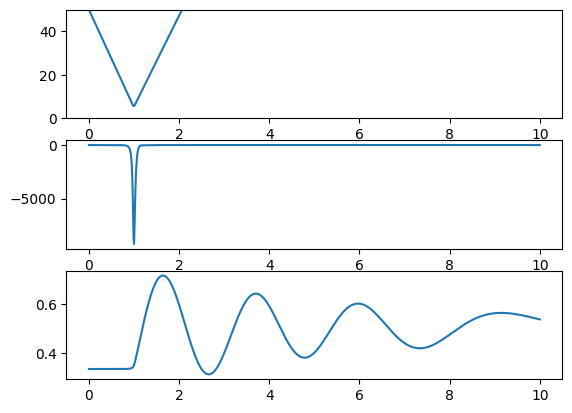

In [706]:

plt.subplot( 3, 1, 1 )
plt.plot( t_eval * au2ps, r_t )
plt.ylim( 0, 50 )

plt.subplot( 3, 1, 2 )

pulse = - alpha * mu**2 / 2 / r_t**6 * ( 1 + 3 * np.cos( th_t )**2 ) / Be

plt.plot( t_eval * au2ps, pulse )

print( np.min(pulse) )


plt.subplot( 3, 1, 3 )

aligment = np.sum( np.abs( Psi_th_t )**2 * x_arr**2, axis = 1 )

plt.plot( t_eval * au2ps, aligment )
# plt.plot( t_eval * au2ps, np.cos(th_t) )
print( np.max( aligment ) )
# plt.ylim( 0.33, 0.4 )

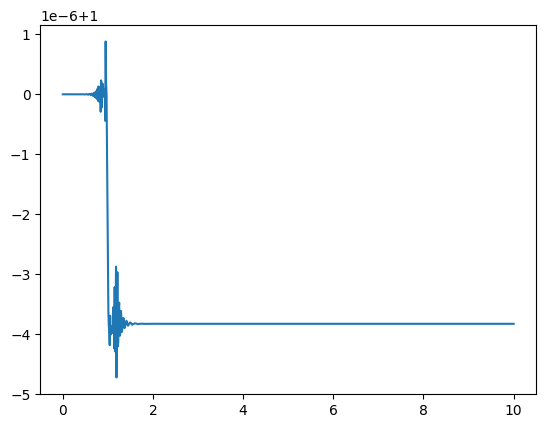

In [707]:
plt.plot( t_eval*au2ps, np.sum( np.abs( Psi_t )**2, axis = 1 ) )

(0.0, 50.0)

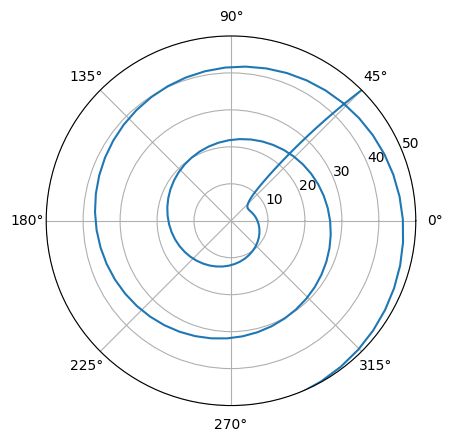

In [708]:
plt.polar( th_t, r_t )
plt.ylim( 0, 50 )

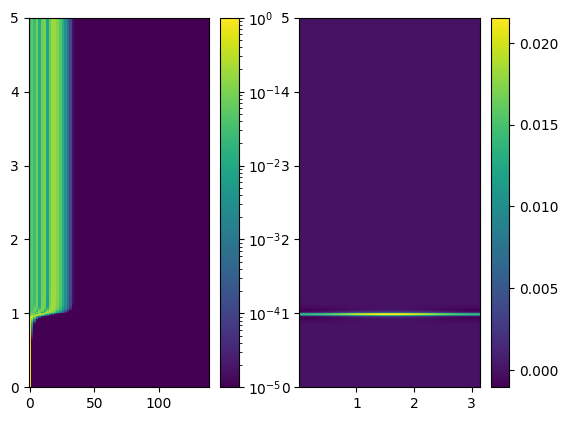

In [709]:
from matplotlib.colors import LogNorm

tlim = (0, 5)

Pleg = get_Pleg_matrix( N_states, omega )
plt.subplot(1, 2, 1)

plt.pcolor( l_arr[j_init%2::2], 
           t_eval * au2ps, 
           np.abs( Psi_t[:, j_init%2::2] )**2, 
           norm=LogNorm(vmin = 1e-5, vmax = 1) )

# plt.pcolor( np.arccos( x_arr ), t_eval * au2ps, np.abs( Psi_th_t )**2 / w, norm=LogNorm() )

plt.colorbar()
plt.ylim( tlim )
# plt.xlim( -0.5,50 )

plt.subplot(1, 2, 2)

th_gr, r_gr = np.meshgrid( np.arccos( x_arr ), np.abs(r_t) )

V_t_arr = potential( r_gr, th_gr, C_12, alpha, mu )

plt.pcolor( np.arccos( x_arr ), t_eval * au2ps, V_t_arr )

plt.colorbar()
plt.ylim( tlim )

pass

In [710]:

import imageio.v3 as iio

images = []


for i in range(0, N_t, 5):

    filename = "../images/{0}.png".format(i)

    plt.figure( figsize=(5,5) )
    # plt.plot( th_arr, np.abs( Psi_th_t[i,:] )**2 / w )
    
    plt.grid()

    plt.ylim( 1e-2, 1e2 )
    plt.semilogy()

    plt.savefig( filename )
    plt.close()

    images.append( iio.imread( filename ) )

iio.imwrite( 'crowd.gif', images, duration = 10, loop = 0 )

25000000.0 0.9364252799999999 187.6039232578177


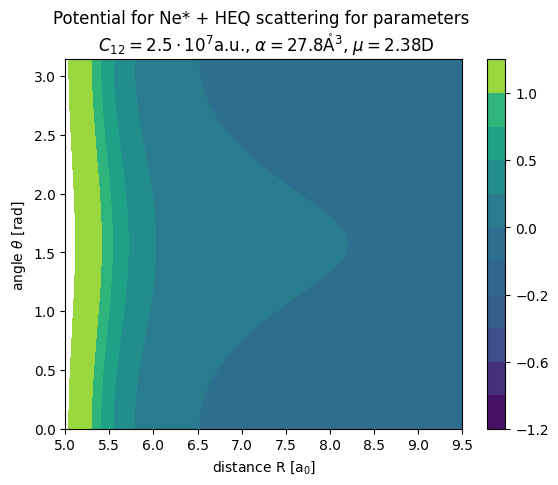

In [711]:
r = np.linspace( 5, 9.5 )
th = np.linspace( 0, np.pi )

r_gr, th_gr = np.meshgrid( r, th )

Db2au = 0.393456 
au2A = 0.529177
au2eV = 27.2

C_12 = 2.5e7
mu = 2.38 * Db2au
alpha = 27.8 / au2A**3

print(C_12, mu, alpha)

V = C_12 / r_gr**12 - mu**2 * alpha / r_gr**6 / 2 * ( 1 + 3 * np.cos( th_gr )**2 )

plt.contourf( r_gr, th_gr, V * au2eV, levels = [-1.2, -0.9, -0.6, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5, 0.75, 1.0, 2.0] )
plt.colorbar()

plt.title( "Potential for Ne* + HEQ scattering for parameters \n" + 
          r" $C_{12} = 2.5 \cdot 10^7 $a.u., $\alpha = 27.8 \mathring{\mathrm{A}}^3$, $\mu = 2.38$D" )
plt.xlabel( r"distance R [a$_0$]" )
plt.ylabel( r"angle $\theta$ [rad] " )

pass



